<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep26-eda-modeling-submission?scriptVersionId=154011906" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

- Version 1 (12/04/2023)
    * EDA 
    * Baseline modeling 1.0.
    

- Version 2 (12/05/2023)
    * Baseline modeling 1.0 updated.
    
    
- Version 3 (12/07/2023)
    * Baseline modeling 1.0 updated.
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e26/train.csv')
test = pd.read_csv('../input/playground-series-s3e26/test.csv')
submission = pd.read_csv('../input/playground-series-s3e26/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (7905, 20)
The dimension of the test dataset is: (5271, 19)


In [3]:
train.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,3952.000000,2030.173308,18373.146490,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,2282.121272,1094.233744,3679.958739,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,0.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1976.000000,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,3952.000000,1831.000000,18713.000000,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,5928.000000,2689.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,7904.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [5]:
test.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000
mean,10540.000000,2038.696642,18497.756782,2.600389,352.486435,3.538071,84.701679,1811.233314,113.587526,115.286094,264.023715,10.632865,3.036995
std,1521.750965,1086.843490,3583.898801,3.852395,200.438989,0.354886,77.542064,1935.351492,48.964789,52.602780,87.584068,0.792711,0.856030
min,7905.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,9222.500000,1234.000000,15730.000000,0.700000,248.000000,3.350000,39.000000,823.000000,75.000000,84.000000,209.000000,10.000000,2.000000
50%,10540.000000,1882.000000,18806.000000,1.100000,299.000000,3.570000,65.000000,1142.000000,106.950000,104.000000,259.000000,10.600000,3.000000
75%,11857.500000,2692.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1838.500000,137.950000,138.000000,317.000000,11.000000,4.000000
max,13175.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,15.200000,4.000000


There are no missing values neither in `train` and `test` datasets.

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

Notice that the data exploration is based on the competition dataset. First, we start by visualizing `Status`, the variable of interest.

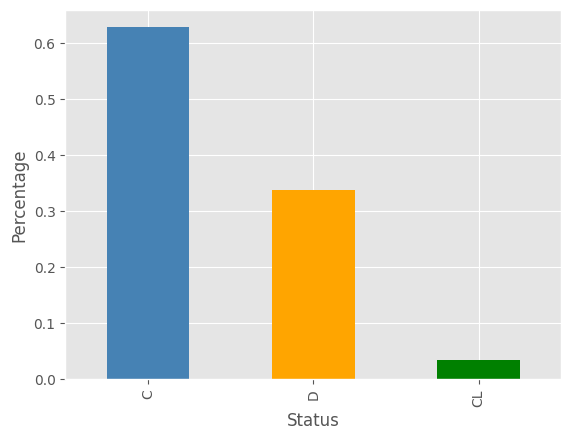

In [6]:
train['Status'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange', 'green'])
plt.ylabel('Percentage');

From the above chart, it is clear that the dataset is imbalanced.

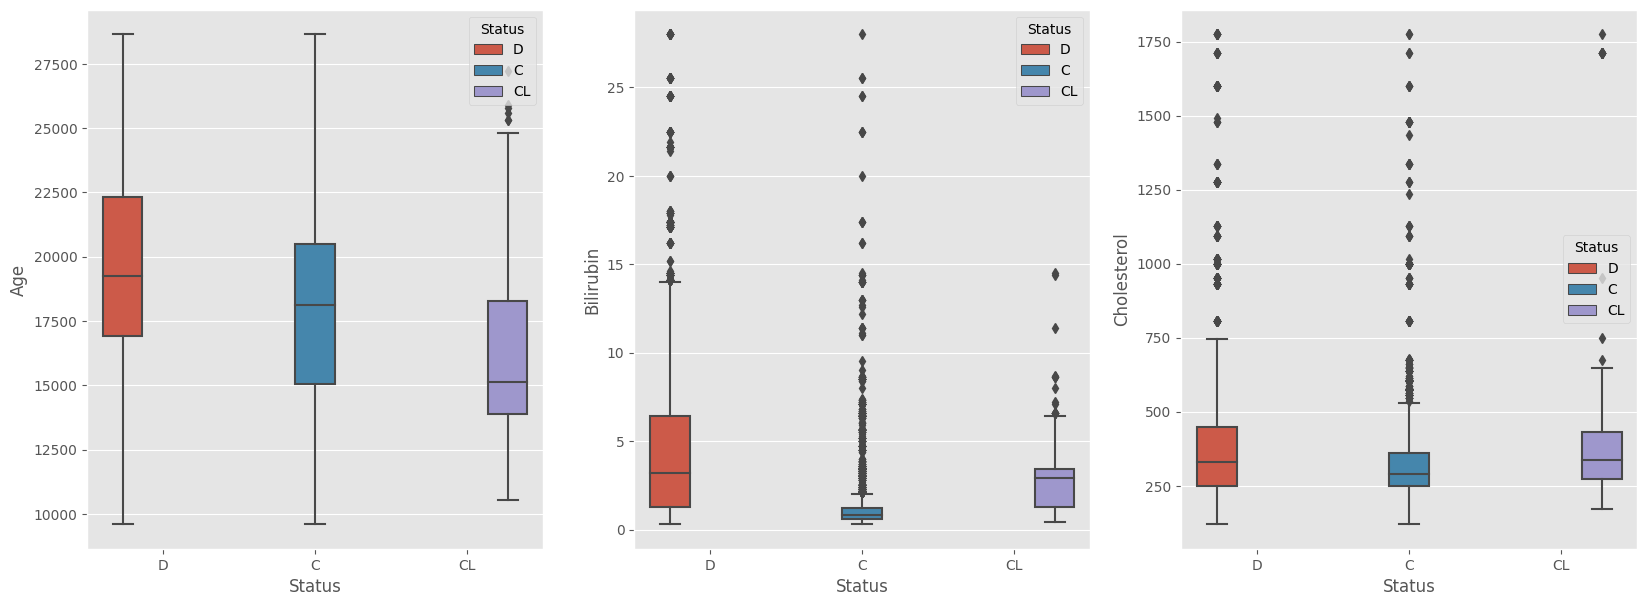

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (20, 7))

sns.boxplot(ax = axes[0], data = train, x = 'Status', y = 'Age', hue = 'Status');
sns.boxplot(ax = axes[1], data = train, x = 'Status', y = 'Bilirubin', hue = 'Status');
sns.boxplot(ax = axes[2], data = train, x = 'Status', y = 'Cholesterol', hue = 'Status');

From the above charts, these are some observations:

- In the left panel, it seems that there is a pattern between `Age` and `Status`. As we move from left to right, the median `Age` decreases.
- In the middle panel, we see there are many outliers. Also, we can see the median `Bilirubin`  of `Status = C` is smaller compared to the other two status.
- In the right panel, we see there are many outliers. Also, there is no much difference between the medians `Cholesterol` of the three groups.

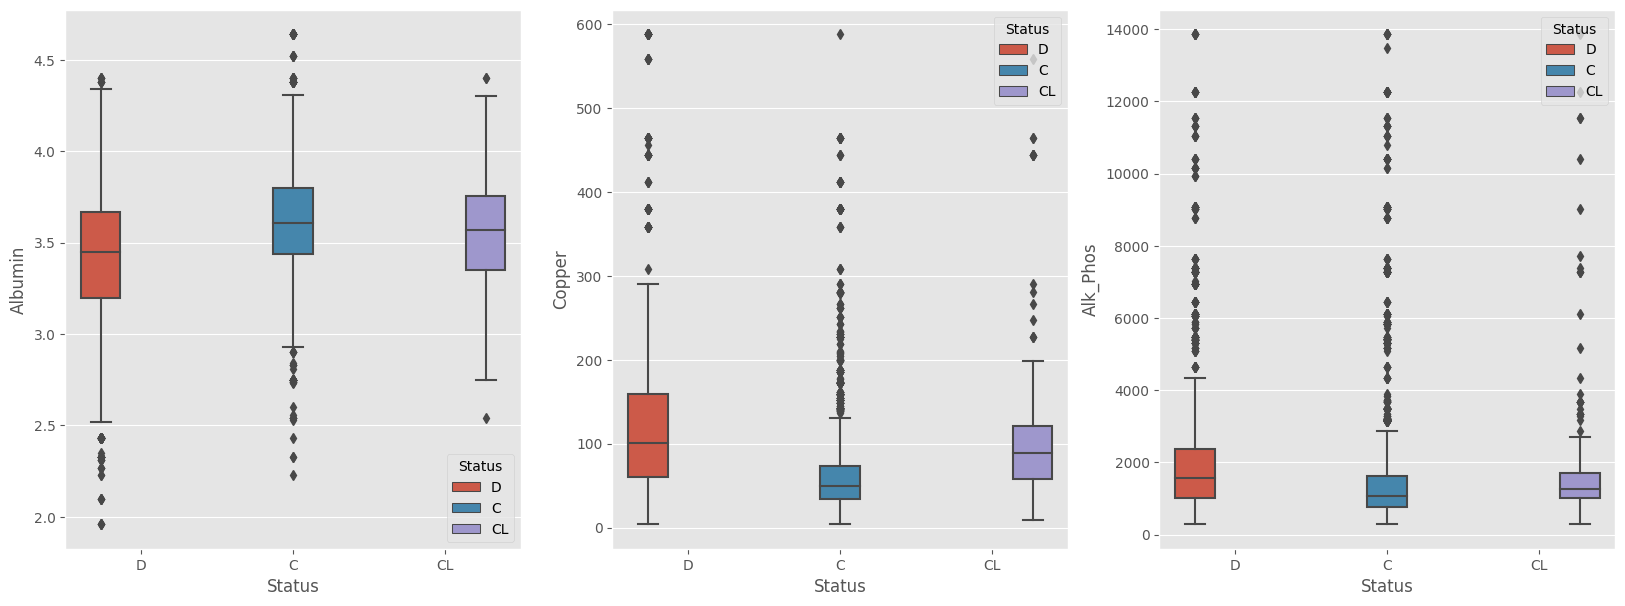

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20, 7))

sns.boxplot(ax = axes[0], data = train, x = 'Status', y = 'Albumin', hue = 'Status');
sns.boxplot(ax = axes[1], data = train, x = 'Status', y = 'Copper', hue = 'Status');
sns.boxplot(ax = axes[2], data = train, x = 'Status', y = 'Alk_Phos', hue = 'Status');

From the above charts, these are some observations:

- In the left panel, the medians `Albumin` of `Status = C` and `Status = CL` are higher compared to the medians `Albumin` of `Status = D`.
- In the middle panel, the median `Copper` of `Status = C` is smaller compared to the other two groups.
- In the right panel, the distribution of the three `Status` groups are similar.

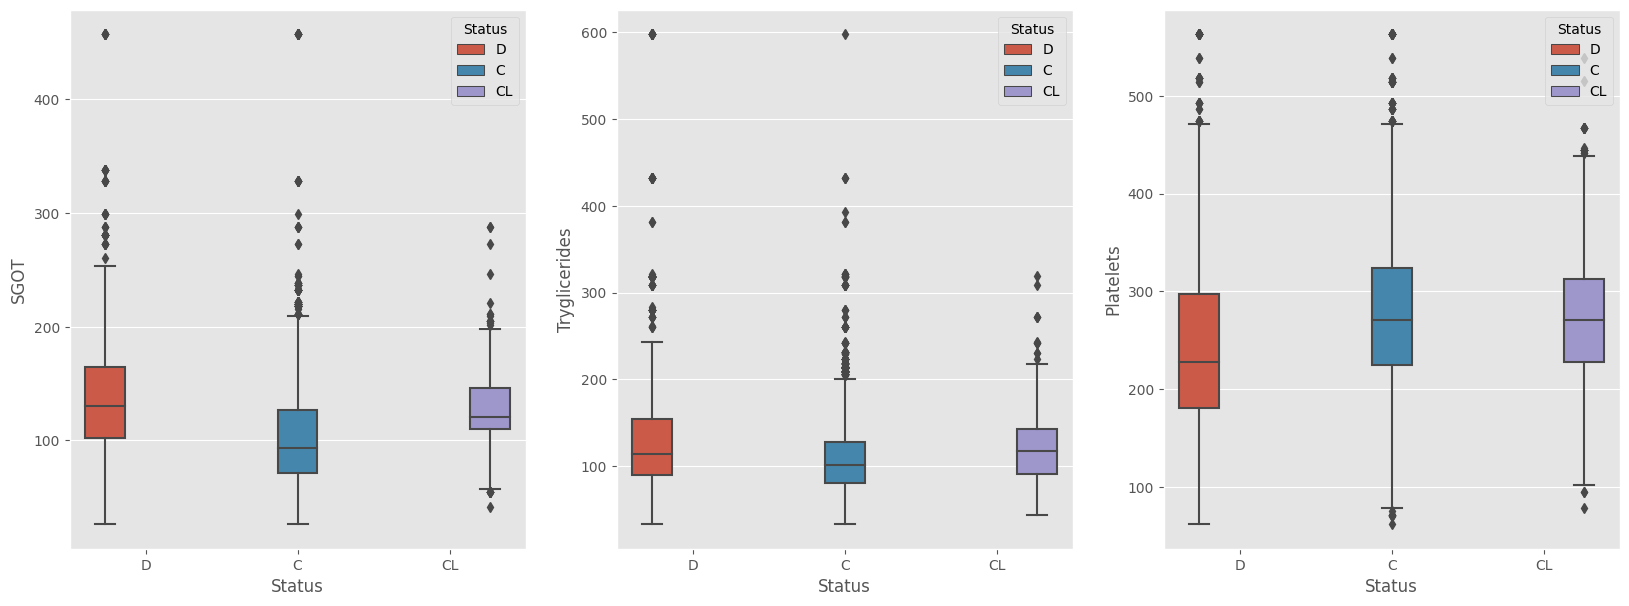

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (20, 7))

sns.boxplot(ax = axes[0], data = train, x = 'Status', y = 'SGOT', hue = 'Status');
sns.boxplot(ax = axes[1], data = train, x = 'Status', y = 'Tryglicerides', hue = 'Status');
sns.boxplot(ax = axes[2], data = train, x = 'Status', y = 'Platelets', hue = 'Status');

From the above charts, these are a couple of observations:

- In the left panel, the median `SGOT` of `Status = C` is smaller compared to the other two groups.
- In the middel panel, the median `Tryglicerides` if `Status = C` is slightly smaller compared to the other two groups.
- In the right panel, the median `Platelets` of `Status = D` is smaller compared to the other two groups.

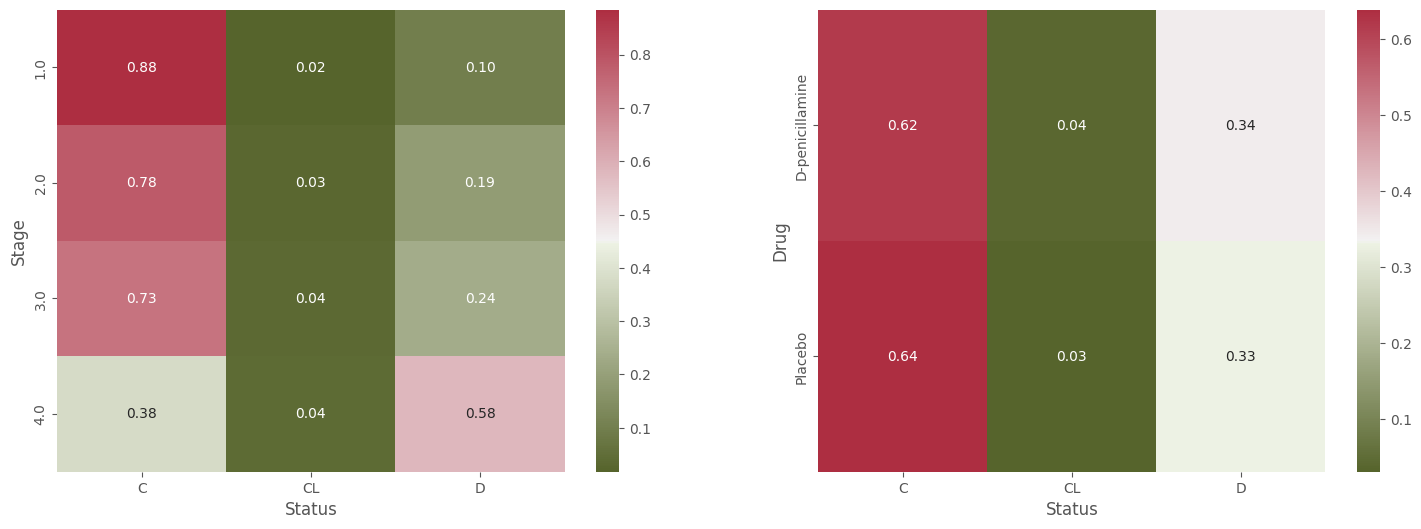

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Stage'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Drug'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- In the left panel, `Stage = 4` has the highest percentage of `Status = D` compared to the other `Stage` groups.
- In the right panel, both `Drug` group have similar `Status = D` percentages.

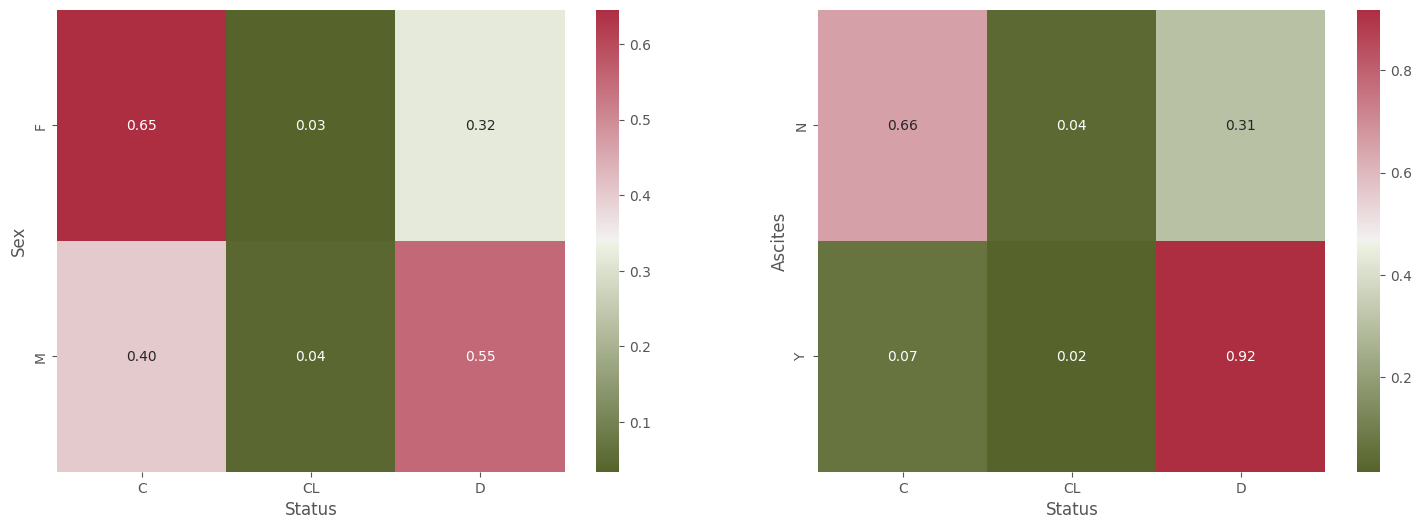

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Sex'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Ascites'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- In the left panel, males have a higher percentage of `Status = D` compared to males. 
- In the right panel, when `Ascites = Y` the percentage of `Status = D` is higher.

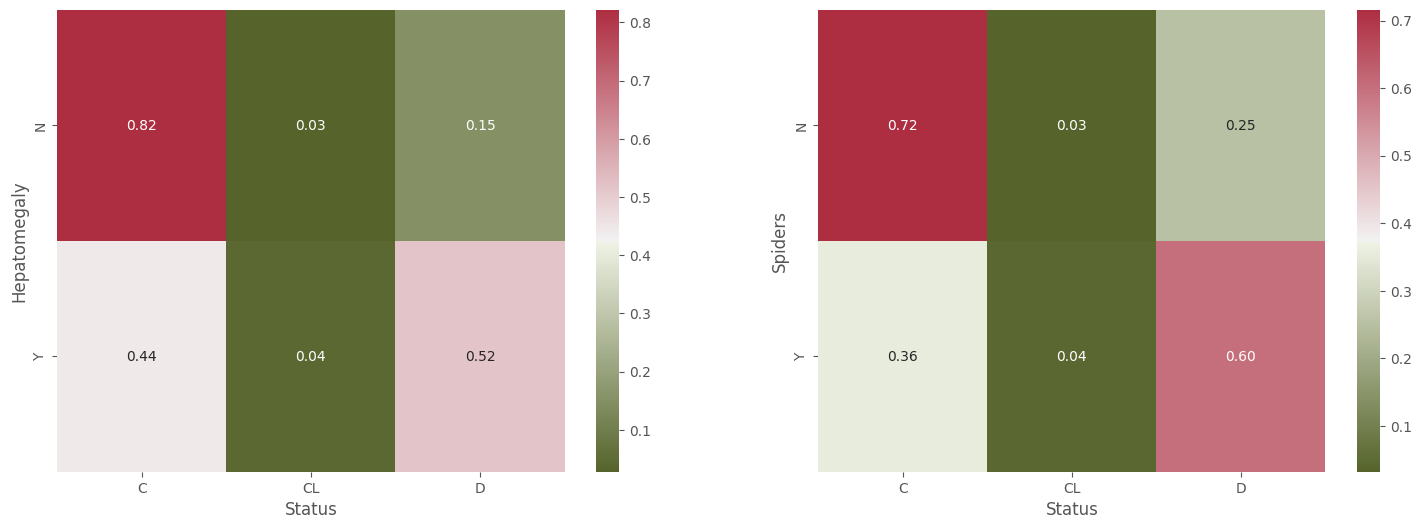

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Hepatomegaly'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Spiders'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- In the left panel, when `Hepatomegaly = Y`, the percentage of `Status = D` is higher compared when `Hepatomegaly = N`
- In the right panel, when `Spiders = Y`, the percentage of `Status = D` is higher compared when `Spiders = N`

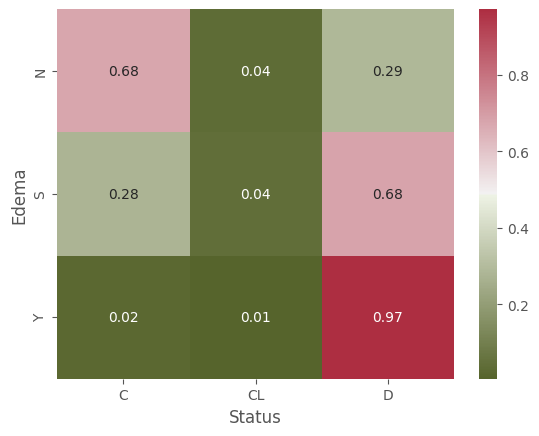

In [13]:
sns.heatmap(data = pd.crosstab(train['Edema'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above chart, we see that when `Edema = Y` the percentage of `Status = D` is higher compared to the other two `Edema` categories.

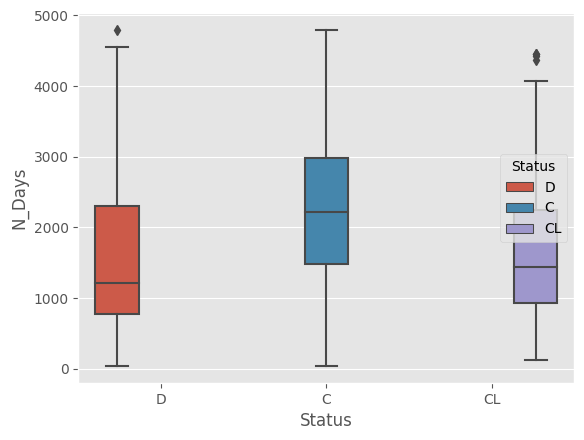

In [14]:
sns.boxplot(data = train, x = 'Status', y = 'N_Days', hue = 'Status');

From the above chart, the median of `N_Days` of `Status = C` is higher compared to the other `Status` categories. 

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start by modeling (using standard models) with raw data with minimum transformation. First, we define the input, target variables and the cross-validation folds.

In [15]:
X = train.drop(columns = ['id', 'Edema', 'Status'], axis = 1)
X['Drug'] = X['Drug'].map({'D-penicillamine': 0, 'Placebo': 1})
X['Sex'] = X['Sex'].map({'F': 0, 'M': 1})
X['Ascites'] = X['Ascites'].map({'N': 0, 'Y': 1})
X['Hepatomegaly'] = X['Hepatomegaly'].map({'N': 0, 'Y': 1})
X['Spiders'] = X['Spiders'].map({'N': 0, 'Y': 1})
X = pd.concat([X, pd.get_dummies(train['Edema'], drop_first = True, dtype = int)], axis = 1)

Y = train['Status'].map({'C': 0, 'CL': 1, 'D': 2})

test_md = test.drop(columns = ['id', 'Edema'], axis = 1)
test_md['Drug'] = test_md['Drug'].map({'D-penicillamine': 0, 'Placebo': 1})
test_md['Sex'] = test_md['Sex'].map({'F': 0, 'M': 1})
test_md['Ascites'] = test_md['Ascites'].map({'N': 0, 'Y': 1})
test_md['Hepatomegaly'] = test_md['Hepatomegaly'].map({'N': 0, 'Y': 1})
test_md['Spiders'] = test_md['Spiders'].map({'N': 0, 'Y': 1})
test_md = pd.concat([test_md, pd.get_dummies(test['Edema'], drop_first = True, dtype = int)], axis = 1)

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

First, we train the `LogistiRegression` model.

In [16]:
logit_cv = cross_val_score(make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'ovr',
                                                                                max_iter = 1000)), 
                           X, 
                           Y, 
                           scoring = 'neg_log_loss',
                           cv = skf, 
                           n_jobs = -1)

print(f"The 10-folds oof Log-Loss score is {-1*logit_cv.mean()}")

The 10-folds oof Log-Loss score is 0.5096954619321861


Next, we train the `RandomForestClassifier` model.

In [17]:
RF_cv = cross_val_score(RandomForestClassifier(criterion = 'log_loss',
                                               n_estimators = 500, 
                                               min_samples_leaf = 3,  
                                               max_depth = 10, 
                                               random_state = 1),
                        X, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The 10-folds oof Log-Loss score of the RF is {-1*RF_cv.mean()}")

The 10-folds oof Log-Loss score of the RF is 0.4615702164423275


Next, we train the `ExtraTreesClassifier` model.

In [18]:
ET_cv = cross_val_score(ExtraTreesClassifier(criterion = 'log_loss',
                                             n_estimators = 500, 
                                             min_samples_leaf = 3, 
                                             max_depth = 15, 
                                             random_state = 2),
                        X, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The 10-folds oof Log-Loss score of the ET is {-1*ET_cv.mean()}")

The 10-folds oof Log-Loss score of the ET is 0.4932015146968382


Next, we train the `HistGradientBoostingClassifier` model.

In [19]:
HB_cv = cross_val_score(HistGradientBoostingClassifier(loss = 'log_loss',
                                                       max_iter = 500, 
                                                       learning_rate = 0.01,
                                                       min_samples_leaf = 15, 
                                                       max_depth = 10, 
                                                       random_state = 3),
                        X, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the HG is {-1*HB_cv.mean()}")

The average 10-folds oof Log-Loss score of the HG is 0.4528599051750163


Next, we train the `LGBMClassifier` model.

In [20]:
LGBM_cv = cross_val_score(LGBMClassifier(n_estimators = 500,
                                         learning_rate = 0.01,
                                         max_depth = 15, 
                                         colsample_bytree = 0.6),
                          X,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM model is {-1*LGBM_cv.mean()}") 

The average 10-folds oof Log-Loss score of the LGBM model is 0.4408499582719633


Next, we train the `XGBClassifer` model.

In [21]:
XGB_cv = cross_val_score(XGBClassifier(n_estimators = 500,
                                       learning_rate = 0.01,
                                       max_depth = 7, 
                                       colsample_bytree = 0.5), 
                          X,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the XGBoost model is {-1*XGB_cv.mean()}") 

The average 10-folds oof Log-Loss score of the XGBoost model is 0.4437094286949009


Next, we train the `CatBoostClassifer` model.

In [22]:
Cat_cv = cross_val_score(CatBoostClassifier(loss_function = 'MultiClass',
                                            iterations = 500,
                                            learning_rate = 0.01,
                                            depth = 8,
                                            verbose = False,
                                            task_type = 'CPU'), 
                          X,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the CatBoost model is {-1*Cat_cv.mean()}") 


The average 10-folds oof Log-Loss score of the CatBoost model is 0.4725461163379158


In [23]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['Logistic', 'RF', 'ET', 'Hist', 'LGBM', 'XGBoost', 'CatBoost']
model_performance['10-folds oof Log-Loss'] = [-1*logit_cv.mean(), -1*RF_cv.mean(), -1*ET_cv.mean(), -1*HB_cv.mean(), -1*LGBM_cv.mean(), -1*XGB_cv.mean(), -1*Cat_cv.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

      Model  10-folds oof Log-Loss
0  Logistic               0.509695
1        RF               0.461570
2        ET               0.493202
3      Hist               0.452860
4      LGBM               0.440850
5   XGBoost               0.443709
6  CatBoost               0.472546


From the above, we see that `LGBM` has the best performance in terms of the Log-Loss. We will ensemble the top four models in a weighted linear fashion as follows:   

- First, we train the models in a 10-folds cross validation framework.
- As we are training the models in the folds, we store the oof predictions of the models.
- After that, we estimate the ``*optimal weight combination*'' by selecting weights at random.

In [24]:
md1 = make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'ovr',
                                                           max_iter = 1000))

md2 = RandomForestClassifier(criterion = 'log_loss',
                             n_estimators = 500, 
                             min_samples_leaf = 3,  
                             max_depth = 10, 
                             random_state = 1)

md3 = ExtraTreesClassifier(criterion = 'log_loss',
                           n_estimators = 500, 
                           min_samples_leaf = 3, 
                           max_depth = 15, 
                           random_state = 2)

md4 = HistGradientBoostingClassifier(loss = 'log_loss',
                                     max_iter = 500, 
                                     learning_rate = 0.01,
                                     min_samples_leaf = 15, 
                                     max_depth = 10, 
                                     random_state = 3)

md5 = LGBMClassifier(n_estimators = 500,
                     learning_rate = 0.01,
                     max_depth = 15, 
                     colsample_bytree = 0.6)

md6 = XGBClassifier(n_estimators = 500,
                    learning_rate = 0.01,
                    max_depth = 7, 
                    colsample_bytree = 0.5)

md7 = CatBoostClassifier(loss_function = 'MultiClass',
                         iterations = 500,
                         learning_rate = 0.01,
                         depth = 8,
                         verbose = False,
                         task_type = 'CPU')

In [25]:
md1_pred, md2_pred, md3_pred, md4_pred, md5_pred, md6_pred, md7_pred = list(), list(), list(), list(), list(), list(), list()
Y_test_list = list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    md1.fit(X_train, Y_train)
    md1_pred.append(md1.predict_proba(X_test))

    md2.fit(X_train, Y_train)
    md2_pred.append(md2.predict_proba(X_test))

    md3.fit(X_train, Y_train)
    md3_pred.append(md3.predict_proba(X_test))

    md4.fit(X_train, Y_train)
    md4_pred.append(md4.predict_proba(X_test))
    
    md5.fit(X_train, Y_train)
    md5_pred.append(md5.predict_proba(X_test))
    
    md6.fit(X_train, Y_train)
    md6_pred.append(md6.predict_proba(X_test))
    
    md7.fit(X_train, Y_train)
    md7_pred.append(md7.predict_proba(X_test))

    Y_test_list.append(Y_test)

After that, we estimate the model predictions weights as follows:

In [26]:
w1_weights, w2_weights, w3_weights = list(), list(), list()
w4_weights, w5_weights, w6_weights = list(), list(), list()
w7_weights, scores = list(), list()

for i in tqdm(range(0, 1000)):
    
    w2 = np.random.random_sample(size = 1)[0]
    w4 = np.random.random_sample(size = 1)[0]
    w5 = np.random.random_sample(size = 1)[0]
    w6 = np.random.random_sample(size = 1)[0]
    
    w2_weights.append(w2)
    w4_weights.append(w4)
    w5_weights.append(w5)
    w6_weights.append(w6)
    
    scores_in = list()
    
    for j in range(0, 10):
        
        pred = w2*md2_pred[j] + w4*md4_pred[j] + w5*md5_pred[j] + w6*md6_pred[j] 
        scores_in.append(log_loss(Y_test_list[j], pred))
    
    scores.append(np.mean(scores_in))
    
results = pd.DataFrame()
results['w_md2'] = w2_weights
results['w_md4'] = w4_weights
results['w_md5'] = w5_weights
results['w_md6'] = w6_weights
results['score'] = scores
results = results.sort_values(by = 'score', ascending = True).reset_index(drop = True)
results.head(10)

  0%|          | 0/1000 [00:00<?, ?it/s]

,w_md2,w_md4,w_md5,w_md6,score
0,0.011258,0.019417,0.420125,0.258074,0.439689
1,0.019586,0.028804,0.986053,0.126113,0.440313
2,0.055926,0.191847,0.228682,0.373158,0.440313
3,0.018770,0.038964,0.139943,0.235132,0.440452
4,0.091986,0.303535,0.517945,0.206727,0.440520
5,0.040335,0.318884,0.136472,0.473921,0.440582
6,0.014161,0.315229,0.135105,0.323689,0.440634
7,0.026650,0.174616,0.302908,0.638771,0.440732
8,0.081315,0.149665,0.819623,0.009198,0.440745
9,0.025038,0.005496,0.789926,0.449947,0.440768


Next, we train the models in the entire data.

In [27]:
md2_fit = md2.fit(X, Y)
md4_fit = md4.fit(X, Y)
md5_fit = md5.fit(X, Y)
md6_fit = md6.fit(X, Y)

Finally, we use the weights that produce the lowest oof `Log-Loss` score to ensemble the best four model predictions.

In [28]:
ens = results['w_md2'][0]*md2_fit.predict_proba(test_md) + results['w_md4'][0]*md4_fit.predict_proba(test_md) + results['w_md5'][0]*md5_fit.predict_proba(test_md) + results['w_md6'][0]*md6_fit.predict_proba(test_md) 
ens = pd.DataFrame(ens)
ens = ens.div(ens.sum(axis = 1), axis = 0)

submission.loc[:, ['Status_C', 'Status_CL', 'Status_D']] = ens.values
submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.621863,0.041045,0.337091
1,7906,0.714117,0.147053,0.138830
2,7907,0.043646,0.020977,0.935378
3,7908,0.945210,0.008416,0.046373
4,7909,0.779181,0.045639,0.175180


In [29]:
submission.to_csv('baseline_sub.csv', index = False)